# 🩺 PySpark Health Data Analysis
Versi Notebook Lengkap dengan Penjelasan & Visualisasi

## 1. Import Library

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

import matplotlib.pyplot as plt
import pandas as pd

## Load Dataset


In [2]:
# This cell is a duplicate - use Cell 6 instead
# spark = SparkSession.builder.appName("Diabetes-Full-Pipeline").getOrCreate()
# df = spark.read.csv("diabetes_012.csv", header=True, inferSchema=True)
# df.printSchema()
# df.show(5)


## 2. Membuat Spark Session

In [3]:
spark = SparkSession.builder.appName("Diabetes-Full-Pipeline").getOrCreate()

df = spark.read.csv("diabetes_012.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)


root
 |-- Diabetes_012: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)

+------------+------+--------+---------+----+------+------+--------------------+------------+------+--

## 3. Mengecek Missing Value

Kita menghitung jumlah nilai kosong di setiap kolom.

In [4]:
df = df.dropna()


## 4. Target Engineering

- Mengisi missing value numerik dengan 0 (bisa diganti median)

In [5]:
df = df.withColumn("label", when(col("Diabetes_012")==2, 1).otherwise(0))


## 5. Check Imbalance

In [6]:
df.groupBy("label").count().show()


+-----+------+
|label| count|
+-----+------+
|    1| 35346|
|    0|218334|
+-----+------+



## 6. Mengatasi Ketidakseimbangan Kelas

Menggunakan *class weight* untuk RandomForest & GBT.

In [7]:
major = df.filter(col("label") == 0)
minor = df.filter(col("label") == 1)

ratio = major.count() / minor.count()

minor_oversampled = minor.sample(withReplacement=True, fraction=ratio, seed=42)
df_balanced = major.union(minor_oversampled)

df_balanced.groupBy("label").count().show()


+-----+------+
|label| count|
+-----+------+
|    0|218334|
|    1|217723|
+-----+------+



## 7. Feature Selection

In [8]:
feature_cols = [c for c in df_balanced.columns if c not in ["label", "Diabetes_012"]]


## 8. VectorAssembler

In [9]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
scaler = StandardScaler(inputCol="features_vec", outputCol="features")


## 9. Training

In [10]:
train, test = df_balanced.randomSplit([0.8, 0.2], seed=42)


## 10. Define Models

In [11]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)


## 11. Pipeline

In [12]:
pipe_lr  = Pipeline(stages=[assembler, scaler, lr])
pipe_rf  = Pipeline(stages=[assembler, scaler, rf])
pipe_gbt = Pipeline(stages=[assembler, scaler, gbt])


## 12. Train Models

In [13]:
model_lr  = pipe_lr.fit(train)
model_rf  = pipe_rf.fit(train)
model_gbt = pipe_gbt.fit(train)


## 13. Predict

In [14]:
pred_lr  = model_lr.transform(test)
pred_rf  = model_rf.transform(test)
pred_gbt = model_gbt.transform(test)


## 14.Model Evaluation (Accuracy, F1, AUC)

In [15]:
acc = MulticlassClassificationEvaluator(metricName="accuracy")
f1  = MulticlassClassificationEvaluator(metricName="f1")
auc = BinaryClassificationEvaluator()

# Evaluate models
lr_acc = acc.evaluate(pred_lr)
lr_f1 = f1.evaluate(pred_lr)
lr_auc = auc.evaluate(pred_lr)

rf_acc = acc.evaluate(pred_rf)
rf_f1 = f1.evaluate(pred_rf)
rf_auc = auc.evaluate(pred_rf)

gbt_acc = acc.evaluate(pred_gbt)
gbt_f1 = f1.evaluate(pred_gbt)
gbt_auc = auc.evaluate(pred_gbt)

metrics = {
    "LR":  {"Accuracy": lr_acc,  "F1": lr_f1,  "AUC": lr_auc},
    "RF":  {"Accuracy": rf_acc,  "F1": rf_f1,  "AUC": rf_auc},
    "GBT": {"Accuracy": gbt_acc, "F1": gbt_f1, "AUC": gbt_auc},
}

print("Model Metrics:")
print(f"LR  - Accuracy: {lr_acc:.4f}, F1: {lr_f1:.4f}, AUC: {lr_auc:.4f}")
print(f"RF  - Accuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}, AUC: {rf_auc:.4f}")
print(f"GBT - Accuracy: {gbt_acc:.4f}, F1: {gbt_f1:.4f}, AUC: {gbt_auc:.4f}")

metrics


Model Metrics:
LR  - Accuracy: 0.7450, F1: 0.7449, AUC: 0.8219
RF  - Accuracy: 0.7369, F1: 0.7367, AUC: 0.8115
GBT - Accuracy: 0.7532, F1: 0.7526, AUC: 0.8305


{'LR': {'Accuracy': 0.745013588834124,
  'F1': 0.744937295976686,
  'AUC': 0.8219138504270616},
 'RF': {'Accuracy': 0.736906352204155,
  'F1': 0.736729268146562,
  'AUC': 0.8115069942196921},
 'GBT': {'Accuracy': 0.753201437191948,
  'F1': 0.7525894044318325,
  'AUC': 0.8304784027287693}}

## 15. Visualisasi


Metrics DataFrame:
     Accuracy        F1       AUC
LR   0.745014  0.744937  0.821914
RF   0.736906  0.736729  0.811507
GBT  0.753201  0.752589  0.830478


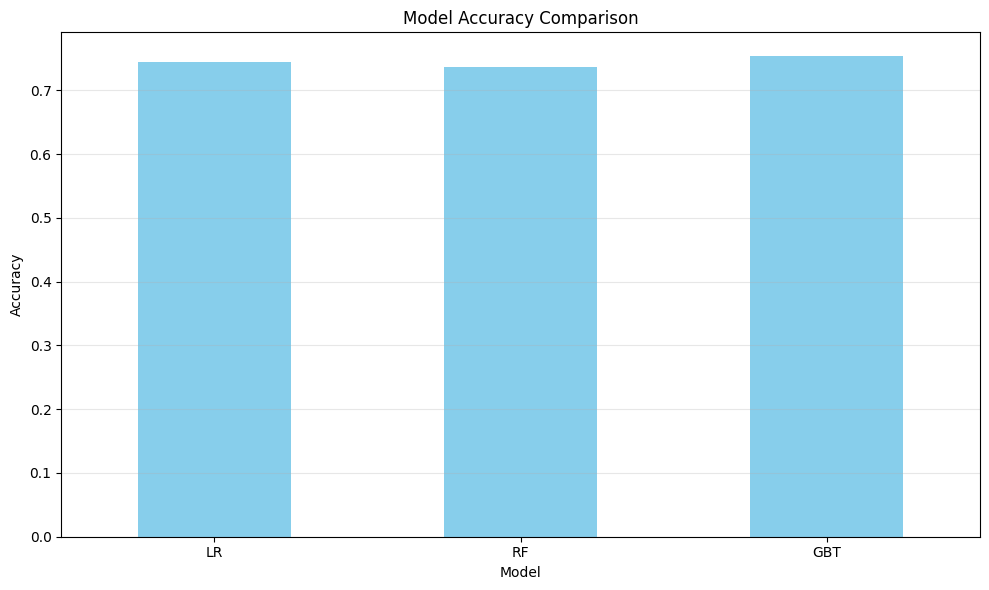

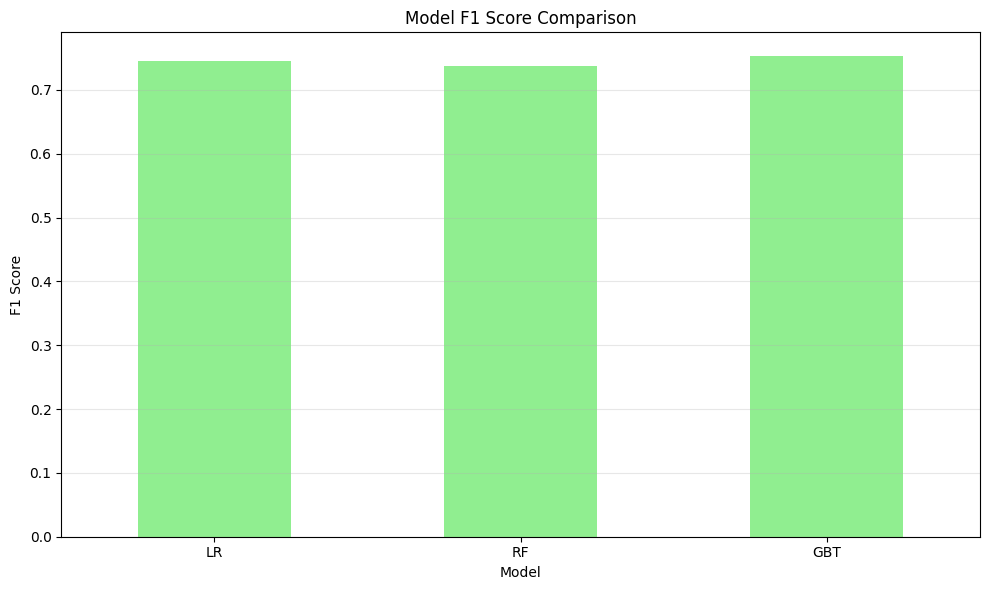

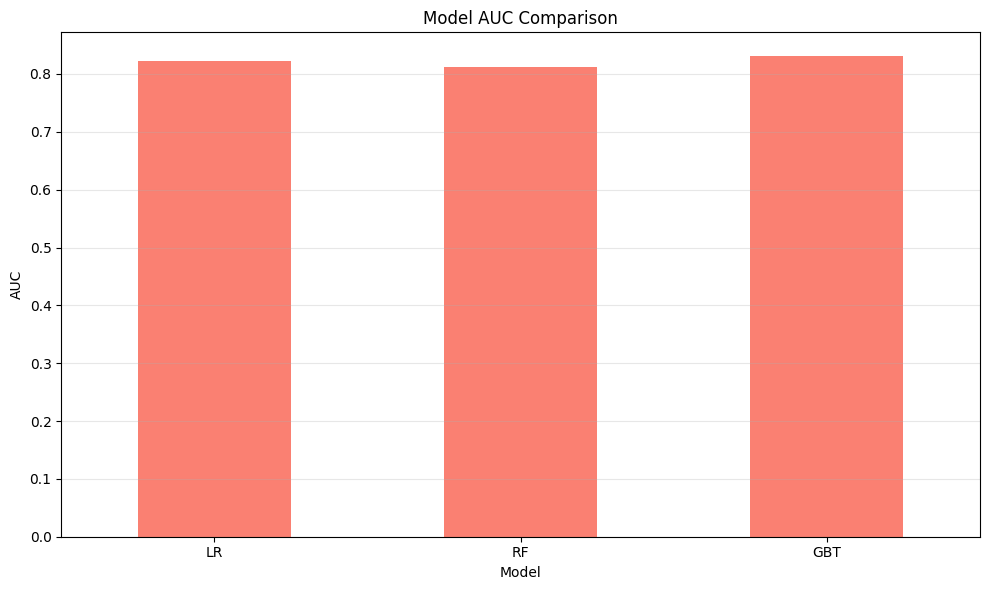

In [16]:
# Convert metrics to DataFrame for visualization
pdf = pd.DataFrame(metrics).T
print("\nMetrics DataFrame:")
print(pdf)

# Plot Accuracy
plt.figure(figsize=(10, 6))
pdf["Accuracy"].plot(kind="bar", color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot F1 Score
plt.figure(figsize=(10, 6))
pdf["F1"].plot(kind="bar", color='lightgreen')
plt.title("Model F1 Score Comparison")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot AUC
plt.figure(figsize=(10, 6))
pdf["AUC"].plot(kind="bar", color='salmon')
plt.title("Model AUC Comparison")
plt.ylabel("AUC")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 16. Feature Importance (RF & GBT)

## Random Forest

In [17]:
rf_model = model_rf.stages[-1]
importances = rf_model.featureImportances.toArray()

pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False).head(20)


,feature,importance
13,GenHlth,0.321788
0,HighBP,0.302753
1,HighChol,0.106014
16,DiffWalk,0.093175
3,BMI,0.075731
18,Age,0.052149
6,HeartDiseaseorAttack,0.015396
20,Income,0.013548
15,PhysHlth,0.006653
19,Education,0.003540


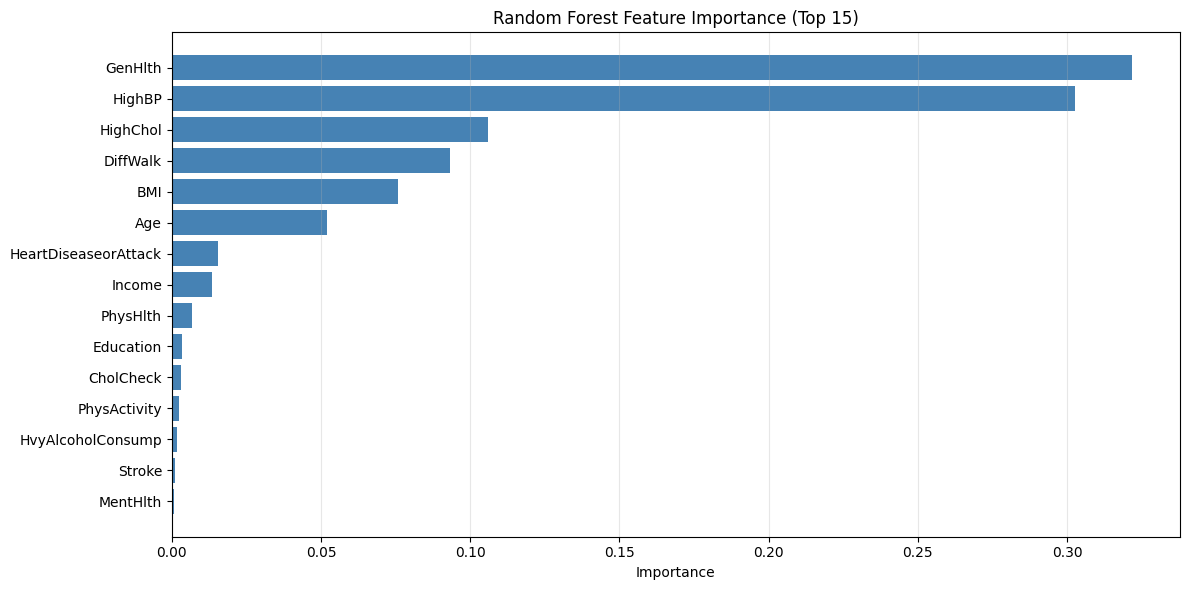

In [18]:
imp_df = pd.DataFrame({"feature": feature_cols, "importance": importances}) \
            .sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(imp_df)), imp_df["importance"], color='steelblue')
plt.yticks(range(len(imp_df)), imp_df["feature"])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance (Top 15)")
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## GBT Importance

In [19]:
gbt_model = model_gbt.stages[-1]
importances_gbt = gbt_model.featureImportances.toArray()

pd.DataFrame({
    "feature": feature_cols,
    "importance": importances_gbt
}).sort_values("importance", ascending=False).head(20)


,feature,importance
3,BMI,0.183823
13,GenHlth,0.155337
18,Age,0.150945
0,HighBP,0.145685
1,HighChol,0.058404
20,Income,0.051156
10,HvyAlcoholConsump,0.040668
17,Sex,0.039994
2,CholCheck,0.039818
16,DiffWalk,0.032668


## 17. Hyperparameter Tuning (Random Forest)

In [20]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Create a new RF model for tuning (to avoid modifying the original)
rf_tune = RandomForestClassifier(featuresCol="features", labelCol="label")
pipe_rf_tune = Pipeline(stages=[assembler, scaler, rf_tune])

# Simplified grid (lebih ringan dan stabil di Windows)
paramGrid = (ParamGridBuilder()
             .addGrid(rf_tune.numTrees, [20, 50])
             .addGrid(rf_tune.maxDepth, [5, 10])
             .build())

acc_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

tvs = TrainValidationSplit(
    estimator=pipe_rf_tune,
    estimatorParamMaps=paramGrid,
    evaluator=acc_evaluator,
    trainRatio=0.8,
    parallelism=1  # sangat penting untuk Windows
)

tvs_model = tvs.fit(train)
best_rf = tvs_model.bestModel

pred_best = best_rf.transform(test)
best_accuracy = acc_evaluator.evaluate(pred_best)
print(f"Best Random Forest Accuracy: {best_accuracy:.4f}")
best_accuracy


Best Random Forest Accuracy: 0.7586


0.758590906997098

## 18. Save Models

In [21]:
# Save the best model (uncomment to save)
# Note: Make sure to run hyperparameter tuning cell first to have best_rf defined
# best_rf.write().overwrite().save("diabetes_rf_model")

# Or save the regular RF model if hyperparameter tuning wasn't run
# model_rf.write().overwrite().save("diabetes_rf_model")

# Stop Spark session (uncomment when done)
# spark.stop()